# **Navigating Healthcare Costs: A Comprehensive Analysis of Medical Costs in the United States**
#### Group 13: Angelina Hsu, Brendan Yuen, Kelly Snow, Jitao Zhang


## Introduction

The lack of healthcare accessibility in the United States poses a threat to all residents who suffer anything from sudden to terminal illness or injuries. An example of this can be seen in those who sought out cancer treatment following diagnosis. In a study period between 2003 and 2006, it was discovered that more than 2 million US cancer survivors did not get necessary medical services due to financial concerns (Weaver et al., 2010). The impact was exacerbated for those coming from low-income and/or minorities groups (Kent et al., 2013). Although controlling healthcare costs is essential for investing in other critical social welfare components like education and infrastructure (Bauchner, 2019), it is equally important to provide accessible healthcare to all residents in the United States.

Using the “Medical Cost Personal Datasets” dataset, we hope to understand which regression method with minimum MSE between Ridge, Lasso, and Full would best predict the Medical Costs (charges) in our dataset.


#### Our Dataset

The dataset we chose comes from a book by Brett Lantz titled "Machine Learning with R", which was published in 2013. The data was collected from a small subset of the USA population, with focuses on residents of 4 regions: northeast, southeast, southwest, northwest. 

Link to dataset: https://www.kaggle.com/datasets/mirichoi0218/insurance 

This dataset contains a total of 1338 observations and 7 variables (descriptions taken directly from Kaggle):
- `age` (double): age of primary beneficiary
- `sex` (character with 2 options: male or female): insurance contractor gender, female, male
- `bmi` (double): Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- `children` (double): Number of children covered by health insurance / Number of dependents
- `smoker`(character with 2 options: yes or no): Smoking
- `region` (character with 4 options: northeast, southeast, southwest, northwest): the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- `charges` (double): Individual medical costs billed by health insurance

## Methods and Results

#### Preparations 

In [2]:
# Loading all needed libraries:
library(tidyverse)
library(tidymodels)
library(broom)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(cowplot)
library(leaps)
library(glmnet)
library(car)
library(faraway)
library(mltools)
library(GGally)
library(ggplot2)
library(gridExtra)

# General Graphs' setting:
options(repr.plot.width = 13, repr.plot.height = 9)   

# Import online dataset
url <- "https://raw.githubusercontent.com/Jitao-Z/Medical-Cost-Personal-Datasets/main/insurance.csv"
raw_data <- read_csv(url)

# First 6 rows of the dataset
head(raw_data)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

age,sex,bmi,children,smoker,region,charges
<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
19,female,27.900,0,yes,southwest,16884.924
18,male,33.770,1,no,southeast,1725.552
28,male,33.000,3,no,southeast,4449.462
33,male,22.705,0,no,northwest,21984.471
32,male,28.880,0,no,northwest,3866.855
31,female,25.740,0,no,southeast,3756.622


### Exploratory Data Analysis (EDA)

#### Data cleaning

In [3]:
medical_cost <- raw_data |>
    filter(!is.na(charges)) |>                        # Check and remove missing values from the raw dataset
    mutate(region = ifelse(region == "southwest" | region == "northwest", "west", "east"),
           children = ifelse(children <= 2, "<=2", ">2"))
medical_cost$sex <- factor(medical_cost$sex)           # Change the property of sex into factor
medical_cost$region <- factor(medical_cost$region)     # Change the property of region into factor
medical_cost$children <- factor(medical_cost$children) # Change the property of children into factor
medical_cost$smoker <- factor(medical_cost$smoker)     # Change the property of smoker into factor

head(medical_cost)

age,sex,bmi,children,smoker,region,charges
<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>
19,female,27.900,<=2,yes,west,16884.924
18,male,33.770,<=2,no,east,1725.552
28,male,33.000,>2,no,east,4449.462
33,male,22.705,<=2,no,west,21984.471
32,male,28.880,<=2,no,west,3866.855
31,female,25.740,<=2,no,east,3756.622


#### Plotting Relevant Raw Data 

As we're exploring the idea of predicting relationships in our project, we wanted to know if multicollinearity would be an issue for our model. To analyze this, we conducted a ggpairs to see if there is multicollinearity that will affect the standard error of our esimates.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


age         sexmale             bmi        children       smokeryes 
       1.016822        1.008900        1.106630        1.004011        1.012074 
regionnorthwest regionsoutheast regionsouthwest 
       1.518823        1.652230        1.529411

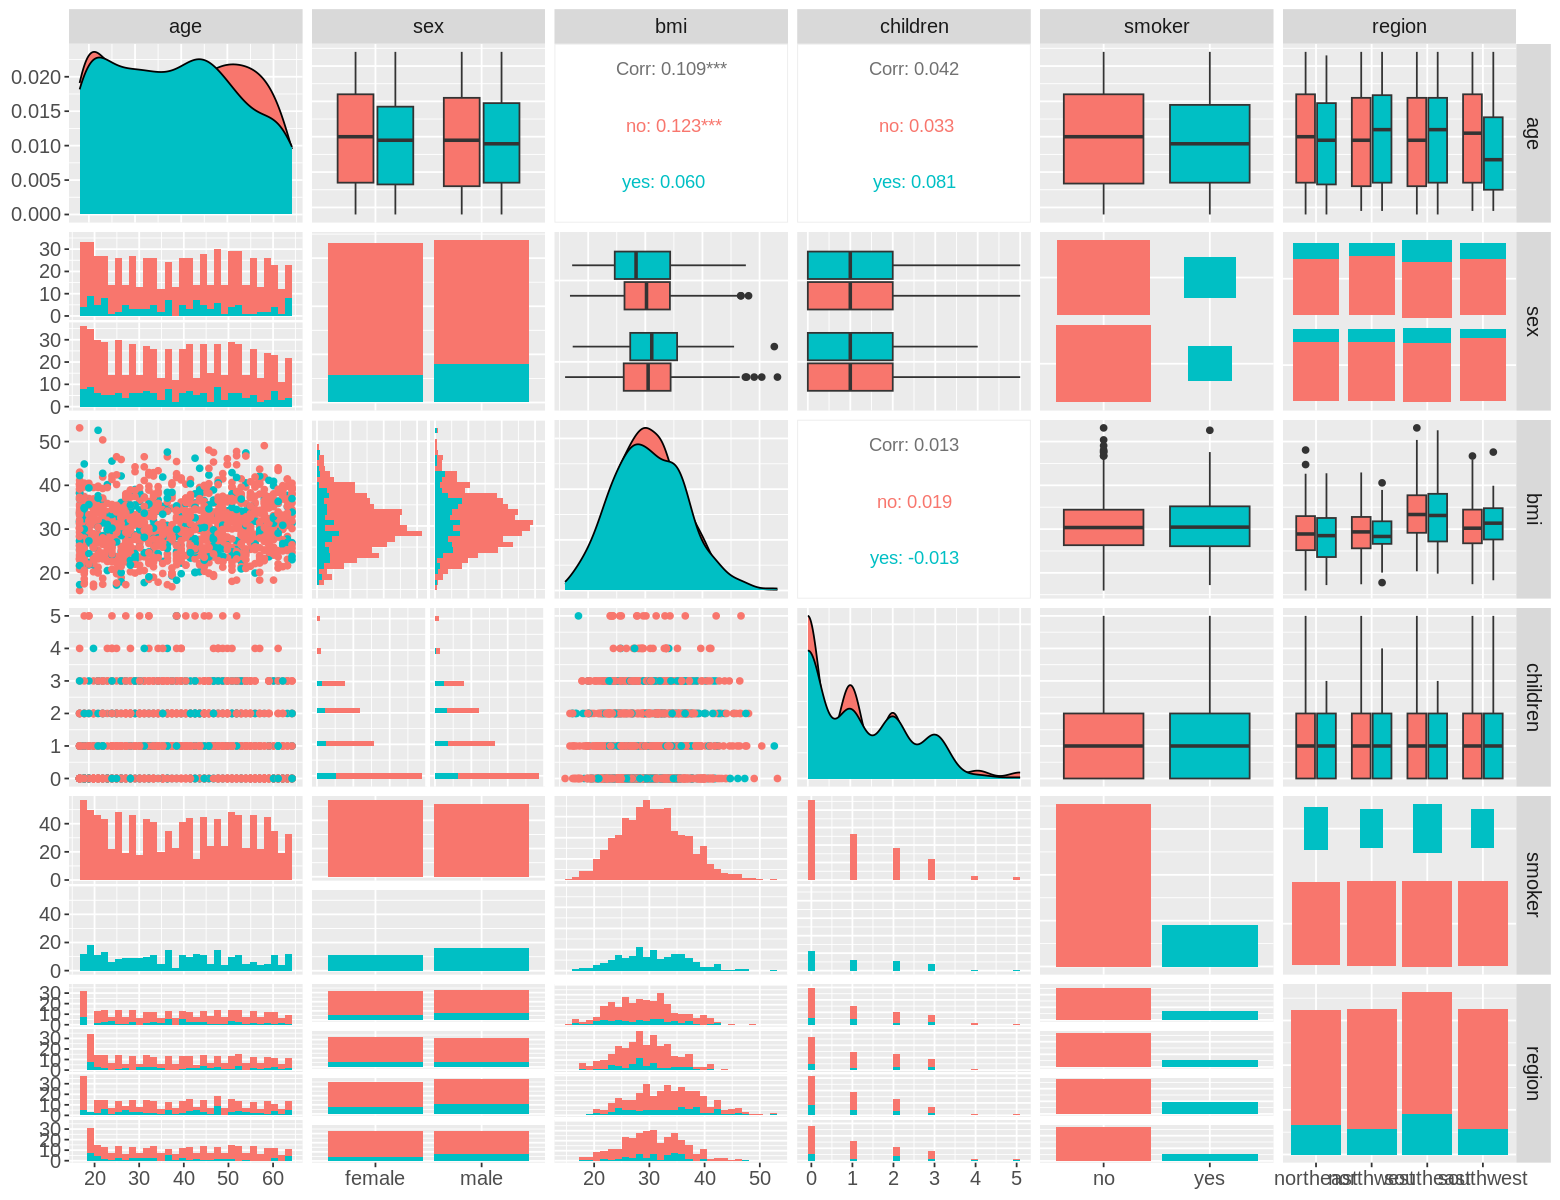

In [4]:
options(repr.plot.width = 13, repr.plot.height = 10)   

insurance_data_plots <- raw_data %>%
  select(-charges) %>% 
  ggpairs(mapping = ggplot2::aes(color = smoker), progress = FALSE) +
  theme(
    text = element_text(size = 15),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  )
insurance_data_plots

vif(lm(charges ~ ., data = raw_data))

From tutorial 5 we learned that "James et al. (2013) in *An Introduction to Statistical Learning* (see Section 3.3.3 in Subsection Collinearity) indicate that, as a rule of thumb, a VIF value that exceeds 5 or 10 is an indicator of a multicollinearity problem". Since all the values are low we will not have a problem with multicollinearity.

### **Methods: Plans**

We used Lasso, Ridge and Least-Squares to obtain three different models to predict charges and compared their predictive performances. Lasso and Ridge shrink estimated coefficients of variables towards zero using a penalty term. Increasing lambda means that the magnitudes of the estimated coefficients decrease even more (James et al., 2013). For our project, we used the default value of lambda which minimizes the Mean-Squared Error (MSE) in the `cv.glmnet()` function. In Lasso, the estimated coefficients obtained minimize the expression in Figure 1 for a given value of lambda (the penalty term is the second term on the RHS) (James et al., 2013):

#### Figure 1: Quantity minimized by Lasso

$$ \sum^n_{i=1}(y_i - \beta_0 - \sum^p_{j=1} \beta_jx_{ij})^2 + \lambda \sum^p_{j=1}|\beta_j| = RSS + \lambda \sum^p_{j=1} |\beta_j| $$
Note: From "Linear Model Selection and Regularization", by James, et al., in _An Introduction to Statistical Learning_ (pp. 203-264). Springer New York. 

Lasso uses the L1 norm in its penalty term shown in Figure 2, meaning that estimated coefficients can be shrunk to exactly zero if lambda is large enough (James et al., 2013). Therefore, Lasso can select variables as variables whose coefficients have been reduced to exactly zero will not be included in the model.

#### Figure 2: Penalty term in Lasso

$$ ||\beta||_1 = \lambda\sum^p_{j=1} |\beta_j| $$
Note: From "Linear Model Selection and Regularization", by James, et al., in _An Introduction to Statistical Learning_ (pp. 203-264). Springer New York. 

On the other hand, the estimated coefficients in Ridge minimize the following expression for a given value of lambda (the penalty term is the second term on the RHS) (James et al., 2013):

#### Figure 3: Quantity minimized by Ridge

$$ \sum^n_{i=1}(y_i - \beta_0 - \sum^p_{j=1} \beta_jx_{ij})^2 + \lambda \sum^p_{j=1} \beta^2_j = RSS + \lambda \sum^p_{j=1} \beta^2_j $$
Note: From "Linear Model Selection and Regularization", by James, et al., in _An Introduction to Statistical Learning_ (pp. 203-264). Springer New York. 

However, Ridge uses the L2 norm in its penalty term shown below, and does not shrink estimated coefficients to exactly zero so it does not select variables. A model obtained by Ridge will include all explanatory variables whereas a model obtained by Lasso may only include a subset (James et al., 2013).

#### Figure 4: Penalty term in Ridge

$$ || \beta ||^2_2 = \lambda\sum^p_{j=1} \beta^2_j $$ 
Note: From "Linear Model Selection and Regularization", by James, et al., in _An Introduction to Statistical Learning_ (pp. 203-264). Springer New York. 

#### **Methods: Summary**

The following is a summary of the method used:
1. Split the dataset into 3 sets - 1 set (50%) is used to train all models, 1 set (25%) is used to select which model is best (selection set), 1 set (25%) is used to test the selected model 
2. Convert all sets into matrix form
3. Use the cv.glmnet function with alpha = 0 (for Ridge) to find the value of lambda which minimizes Mean-Squared Error (MSE) using cross-validation with the training set
4. Extract the estimated coefficients of the regularized model with lambda which minimizes MSE
5. Use the regularized model to predict charges in the selection set and compute the Root Mean-Squared Error (RMSE)
6. Repeat steps 3-5 but change alpha = 1 (for Lasso)
7. Fit a full linear regression model with Least-Squares to the training set
8. Use the full linear regression model to predict charges in the selection set and compute the RMSE
9. Compare the RMSE for each model and select the model which has the lowest RMSE
10. Use the selected model to predict charges in the test set and compute the RMSE for the test set


#### Reasons for Method and Limitations

We split the dataset into 3 sets as we cannot use the same data to fit a model, select a model and make predictions. We decided to have the highest percentage of data in the training set to expose the model to as much data as possible so it would have the best possible predictive performance. Besides this, the exact percentages were arbitrarily chosen. It is appropriate to use Ridge and Lasso to obtain models as they aim to increase a model's predictive performance by reducing the variance of the predictions. However, a limitation is that they create bias in the estimated coefficients (James et al., 2013).


Another limitation is that we are using Ridge and Lasso with data that has categorical variables which may be problematic. As a work-around, we transformed the categorical variables so that each one has only two levels. So, there is one dummy variable for each categorical variable and if the coefficient of a dummy variable has been shrunk to exactly 0, Lasso will not select it. 


#### Ridge, Full regression, Lasso

In [5]:
# Set seed to obtain reproducible results
set.seed(1234)

# Split the data into 3 sets - 1 training set, 1 selection set (for selecting a model), 1 testing set (to make predictions with the selected model)
medical_split <- initial_split(medical_cost, prop = 0.5, strata = charges)
medical_training <- training(medical_split)
medical_remaining <- testing(medical_split)

medical_split_remaining <- initial_split(medical_remaining, prop = 0.5, strata = charges)
medical_select <- training(medical_split_remaining)
medical_testing <- testing(medical_split_remaining)


# Change all sets into matrix form required by "glmnet( )"
medical_matrix_X_train <- model.matrix(charges ~ ., medical_training)[, -1]

medical_matrix_Y_train <- as.matrix(medical_training$charges, ncol = 1)

medical_matrix_X_select <- model.matrix(charges ~ ., medical_select)[, -1]

medical_matrix_Y_select <- as.matrix(medical_select$charges, ncol = 1)

medical_matrix_X_test <- model.matrix(charges ~ ., medical_testing)[, -1]

medical_matrix_Y_test <- as.matrix(medical_testing$charges, ncol = 1)

- Ridge

In [6]:
# Provide different levels of lambda on the model to obtain their respective MSE
medical_cv_lambda_ridge <- cv.glmnet(
    x = medical_matrix_X_train, y = medical_matrix_Y_train,
    alpha = 0)               # alpha = 0: Ridge penalty
                             # Here, we do not explicitly set up a range of values for lambda; therefore, the function will use its default argument of lambda for us
medical_cv_lambda_ridge


Call:  cv.glmnet(x = medical_matrix_X_train, y = medical_matrix_Y_train,      alpha = 0) 

Measure: Mean-Squared Error 

    Lambda Index  Measure      SE Nonzero
min    915   100 39238706 2336500       6
1se   2320    90 41466296 2598432       6

In [7]:
# Obtain the lambda that provides the smallest MSE
medical_lambda_min_MSE_ridge <- medical_cv_lambda_ridge$lambda.min
medical_lambda_min_MSE_ridge

[1] 915.0401

In [8]:
# Obtain the estimated coefficients of our regularized model by selecting the lambda which provides the smallest MSE
medical_ridge_min_coef <- coef(medical_cv_lambda_ridge, s = "lambda.min")    
medical_ridge_min_coef

7 x 1 sparse Matrix of class "dgCMatrix"
                    s1
(Intercept) -8818.7108
age           246.3660
sexmale      -286.2098
bmi           262.5419
children>2    519.2378
smokeryes   21620.1545
regionwest   -286.2766

In [9]:
# Apply our regularized model on our selection set to predict the corresponding response variable, charges and evaluate the model.
medical_select_pred_ridge_min <- predict(medical_cv_lambda_ridge, newx = medical_matrix_X_select, s = "lambda.min")
head(medical_select_pred_ridge_min)

,lambda.min
1,6074.724
2,2821.808
3,2475.190
4,3163.427
5,3032.156
6,5120.299


In [10]:
# Calculate the RMSE for the Ridge regression model in the selection set and present it in a table
medical_RMSE_select <- tibble(
    Model = "Ridge Regression with minimum MSE",
    RMSE_selection_set = rmse(preds = medical_select_pred_ridge_min, actuals = medical_matrix_Y_select))
medical_RMSE_select

Model,RMSE_selection_set
<chr>,<dbl>
Ridge Regression with minimum MSE,6175.794


- Lasso

In [11]:
# Provide different levels of lambda on the model to obtain their respective MSE
medical_cv_lambda_LASSO <- cv.glmnet(
    x = medical_matrix_X_train, y = medical_matrix_Y_train,
    alpha = 1)               # alpha = 1: Lasso penalty
                             # Here, we do not explicitly set up a range of values for lambda; therefore, the function will use its defalut argument of lambda for us
medical_cv_lambda_LASSO


Call:  cv.glmnet(x = medical_matrix_X_train, y = medical_matrix_Y_train,      alpha = 1) 

Measure: Mean-Squared Error 

    Lambda Index  Measure      SE Nonzero
min   72.5    53 38493176 2751775       6
1se  981.2    25 41118155 3376012       3

In [12]:
# Obtain the lambda that provides the smallest MSE
medical_lambda_min_MSE_LASSO <- medical_cv_lambda_LASSO$lambda.min
medical_lambda_min_MSE_LASSO

[1] 72.51536

In [13]:
# Obtain the estimated coefficients of our regularized model by selecting the lambda which provides the smallest MSE
medical_LASSO_min_coef <- coef(medical_cv_lambda_LASSO, s = "lambda.min")    
medical_LASSO_min_coef

7 x 1 sparse Matrix of class "dgCMatrix"
                     s1
(Intercept) -10023.7696
age            259.9346
sexmale       -304.1013
bmi            272.9315
children>2     333.1921
smokeryes    23137.3635
regionwest    -115.0766

In [14]:
# Apply our regularized model on the selection set to predict the corresponding response variable, charges, and evaluate the model
medical_select_pred_LASSO_min <- predict(medical_cv_lambda_LASSO, newx = medical_matrix_X_select, s = "lambda.min")
head(medical_select_pred_LASSO_min)

,lambda.min
1,5757.220
2,2158.676
3,1992.326
4,2687.630
5,2551.165
6,4742.111


In [15]:
# Calculate the RMSE for the Lasso model in the selection set and present it in a table 
medical_RMSE_select <- medical_RMSE_select |> add_row(
    Model = "Lasso Regression with minimum MSE",
    RMSE_selection_set = rmse(preds = medical_select_pred_LASSO_min, actuals = medical_matrix_Y_select))
medical_RMSE_select

Model,RMSE_selection_set
<chr>,<dbl>
Ridge Regression with minimum MSE,6175.794
Lasso Regression with minimum MSE,6109.997


- Full regression

In [16]:
# We can also fit a full linear regression model on our training set
medical_full_OLS <- lm(charges ~ ., data = medical_training)

In [17]:
# At this point, we can compare the estimated coefficients of all of our three obtained models
medical_reg_coef <- round(cbind(
    Full_OLS = coef(medical_full_OLS),
    Ridge_min = as.vector(medical_ridge_min_coef), 
    Lasso_min = as.vector(medical_LASSO_min_coef)), 1) |> as.data.frame()
medical_reg_coef

,Full_OLS,Ridge_min,Lasso_min
,<dbl>,<dbl>,<dbl>
(Intercept),-10483.1,-8818.7,-10023.8
age,264.8,246.4,259.9
sexmale,-489.4,-286.2,-304.1
bmi,284.2,262.5,272.9
children>2,561.6,519.2,333.2
smokeryes,23348.1,21620.2,23137.4
regionwest,-255.5,-286.3,-115.1


In [18]:
# Apply our full linear regression model to the selection to predict the corresponding response variable, charges, and evaluate the model
medical_select_full_OLS <- predict(medical_full_OLS, medical_select)

In [19]:
# Calculate the RMSE of the full linear regression model in the selection set and add it to our previous table
medical_RMSE_select <- medical_RMSE_select |>
    add_row(Model = "OLS Full Regression",
            RMSE_selection_set = rmse(preds = medical_select_full_OLS, actuals = medical_select$charges))
medical_RMSE_select

Model,RMSE_selection_set
<chr>,<dbl>
Ridge Regression with minimum MSE,6175.794
Lasso Regression with minimum MSE,6109.997
OLS Full Regression,6107.096


We selected the full linear regression model as it has the lowest RMSE in the selection set and used
it to predict charges in the test set. We then computed the RMSE for this model in the test set.

In [20]:
medical_test_full_OLS <- predict(medical_full_OLS, medical_testing)
medical_RMSE_select_test <- tibble(Selected_Model = "OLS Full Regression",
                            RMSE_test_set = rmse(preds = medical_test_full_OLS, actuals = medical_testing$charges))
medical_RMSE_select_test

Selected_Model,RMSE_test_set
<chr>,<dbl>
OLS Full Regression,5967.803


### Results

The MSE is given by the formula in Figure 5 and the RMSE is the square root of the MSE:

#### Figure 5: MSE Formula
$$ \frac{1}{n} \sum^n_{i=1} (y_i- \hat{y}_i)^2 $$
Note: From Goodness of Fit and Nested Models lecture slides, by Freue, G. C. (2023). University of British Columbia, Statistical Modelling For Data Science.

A low RMSE indicates high predictive performance as this means the predicted responses are close to the observed responses on average. On the other hand, a high RMSE indicates a poor predictive performance as this means the predicted responses are far from the observed responses on average (Freue, 2023). The Ridge model has the highest RMSE (6175.794), meaning that it is the worst at predicting charges in the selection set. The second best is the Lasso model with the second highest RMSE (6109.997). The best is the full linear regression using Least Squares as it has the lowest RMSE (6107.096). However, it is important to note that these RMSE values are only computed with one portion of the data and a different portion could yield different results. Given the full linear regression model performed best in the selection set, we used it to predict charges in the test set. This produced a test RMSE of 5967.803 which is better than the RMSE obtained in the selection set. 

## Discussion

To summarize our results: The Ridge model had the highest RMSE (6175.794), followed by the Lasso model (6109.997), and finally the full linear regression model (6107.096). Our findings implies that given the variables in our dataset, we are able to obtain the most accurate results using the full regression model.

Our result is different from what we expected. Initially, we thought Ridge or Lasso could give us better approximations than the full model. However, our results suggest that full model regression gives us better predictions with the lowest RMSE. Even though this is not in our expectations, this result is still reasonable to some degree. For instance, we combine four levels of the categorical variable “region” into having only binary levels. Data manipulations like this could result in different model fitting and, thus, different prediction accuracy. Moreover, using Ridge or Lasso does not guarantee that these methods will be better than a full regression model. Therefore, even though the result we obtained is not in line with our expectations, it is still reasonable to get our result.

Transforming the categorical variables in our dataset into binary variables in order to use Lasso and Ridge might have negatively impacted the predictive performances of our models in the selection set as this simplifies the data when it is actually more complex. Instead of doing this, a better way to form models with categorical variables is to use the stepAIC function. This function performs forwards and backwards selection using the AIC (Akaike Information Criterion) as a model evaluation metric (Korner-Nievergelt et al., 2015). The lower the AIC of a model, the better its predictive performance (Korner-Nievergelt et al., 2015). This method is better as it considers each categorical variable and all of its levels as a whole when removing or adding variables to the model. stepAIC works even if the data involves categorical variables with many levels. Therefore, if we use stepAIC, then we do not have to transform the categorical variables into binary variables which means that we may be able to obtain a model with better predictive performance. 

This leads to two areas that future research could look into further:
- Because we had to binarize the region feature, how do medical costs vary across different regions within the United States? Are there specific regional factors beyond those included in the dataset that significantly impact healthcare expenses?
- How do these predictive models compare with existing healthcare cost estimation methods or models used in the healthcare industry? Does this model of lasso/ridge/ or linear regression perform better or worse?



## References

Bauchner H. (2019). “Rationing of Health Care in the United States: An Inevitable Consequence of Increasing Health Care Costs”. *JAMA*. 321:751–752. https://doi.org/10.1001/jama.2019.1081 

James, et al. (2013). “Linear Model Selection and Regularization”. In James, et al., *An Introduction to Statistical Learning* (pp. 203-264). Springer New York. https://doi.org/10.1007/978-1-4614-7138-7 

Kent, E.E., Forsythe, L.P., Yabroff, K.R., Weaver, K.E., de Moor, J.S., Rodriguez, J.L. and Rowland, J.H. (2013). “Are survivors who report cancer-related financial problems more likely to forgo or delay medical care?”. *Cancer*, 119:3710-3717. https://doi.org/10.1002/cncr.28262 

Freue, G. C. (2023). Lecture: Goodness of Fit and Nested Models [Lecture slides]. University of British Columbia, Statistical Modelling For Data Science. Canvas: https://canvas.ubc.ca 

Korner-Nievergelt, et al. (2015). “Model Selection and Multimodel Inference”. In Korner-Niever, et al., *Bayesian Data Analysis in Ecology Using Linear Models with R, BUGS, and Stan* (pp. 175-196). https://doi.org/10.1016/C2013-0-23227-X  
